# How to eat a cake?

In [153]:
# SET UP
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots Optim Interpolations
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`


      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
  [429524aa] Optim v1.4.1


## The simple cake eating problem

Suppose that you have a cake of size $K$. You can eat today the whole cake, but you will be hungry in the future. Or you can eat small pieces every day. The question is: how much of the cake would you eat each day?

Of course, preferences play an important role, we assume that you like eating cake, and that when you are eating it in any given day first slices seems tastier than the latter, which can be generalized in a instantaneous utility function which $u'(c)>0$ and $u''(c)<0$. Also, you are impatient, therefore we can assume that your intetemporal utility function is given by $U(\{c\}_{t=0}^\infty)=\sum_{t=0}^\infty \beta^t u(c_t)$. 

The unit of time are days represented by $t \in \{1;2;3;...T\}$. The cake does not spoil or grow, so $K_t=K_{t-1}-c_{t-1}$. So what to do?

If $T=2$ the problem is quite simple, we can use real analysis, that is we want to find $c^*\in R^2$ that maximices the utility. If $T=\infty$ we have a problem, we are in a diferent *space*, no longer in $R^n$. We are not looking for a vector we are looking for a sequence $\{c\}_{t=0}^\infty$, we can think about it as an infinite dimension vector, or as a function (that's why *function* analysis is used).

### What would you do if you know that tomorrows the world ends?

It is a dramatic way to think the above problem with (a finete $T$) as if you were at time $T-1$. Let's write the problem a little more *Bellman*:

$$
V_{T-1}(K_{T-1})=max_{c_{T-1},c_T} \{ u(c_{T-1})+\beta u(c_T) \} \text{   subject to:   }K_{T-1}=c_{T-1}+c_T   \}
$$

With an easier notation, and knowing that the last period consumption will be $c_T=K_T$, so the value function of last period would be $V_T(K')=u(K')$

$$
V_{T-1}(K)=max_{c} \{ u(c)+\beta V(K') \} \text{   subject to:   } K'=K-c
$$


Suppose $u(c)=ln(c)$. It is easy to solve it with pen and paper. How to solve it with Julia?

Let put some numbers: $\beta=0.9$ $K_{T-1}=100$


### A not very efficent Algorithm

I think it is useful to understand a simple method of how to find a maximun. It could give some intuition on how is a computer approach to optimization rather than the typical derivative equals 0 with pen and paper.

The mian idea is to try a lot of values for $c$ and take the one that gives the greatest value.

We know that $c\in [0,K]$, but there are infinite many options, so we discretizise the space. For example, since $K=100$ we can define $C=\{0,1,2,...,100\}$

Then we evaluate the function in everý point.

Finally we choose the greatest.

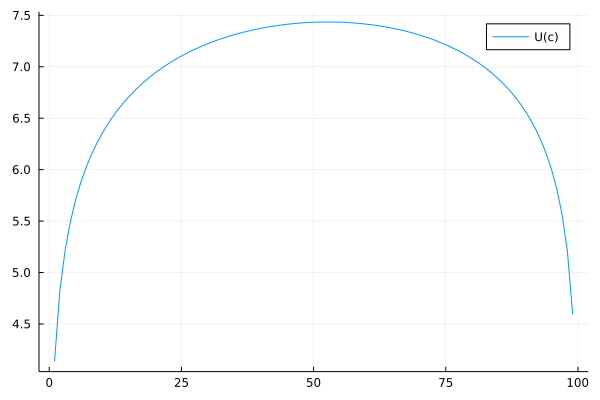

In [109]:
# Create a vector C that is the discretized version of the consumtion domain avoiding ln(0)
C = 1:99

# Define the objetive funcion
U(c,k) = log(c) + β * log(k-c)

# Define the parameters
K=100
β=0.9

# Calculate the image of the function for the dicretized set C
U_img = U.(C,K)
# The point indicate that the operation is element wise, for each element of C

using Plots    # it will take a long time to run for the first time
plot(C,U_img,label="U(c)")

In [102]:
# Let's take the maximun value
(V,pos)=findmax(U_img)
println("El valor máximo de la función objetivo es ",round(V,digits=1),"\ny se encunetra en la posición ", pos)
c_max = C[pos] # reduntante en este caso
println("El valor de consumo que maximiza la utilidad intertemporal es ",c_max)


El valor máximo de la función objetivo es 7.4
y se encunetra en la posición 53
El valor de consumo que maximiza la utilidad intertemporal es 53


### Using a solver
The solver `Optim.jl` works fine for us

In [126]:
# Define the objetive funcion
U(c,k) = log(c) + β * log(k-c)

# Since K is fixed, define a specification of the function such that k=K
# So solver will work with c.
u(c)=U(c,K)

# optimize(function, lower_bound, upper_bound, ...)
maximize(u, 0.0, 100.0)


Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 100.000000]
 * Minimizer: 5.263158e+01
 * Minimum: -7.435477e+00
 * Iterations: 9
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 10

In [133]:
# For selecting a specific result
result=maximize(u, 0.0, 100.0)
@show V = Optim.maximum(result)
@show c_max = Optim.maximizer(result);

V = Optim.maximum(result) = 7.43547650555778
c_max = Optim.maximizer(result) = 52.6315790409608


### What if the cake would  have been different?

We didn't find a *function* $V_{T-1}(K_{T-1})$. We found an specific value of its image given an specific value of $K_{T-1}$.

What is a *function*? For now, let's say it is set of order pairs, e.g. $f=\{(x,y):y=f(x)\}$, this is convinient for a computational perspective. Although, Julia can deal with closed form functions as we usually think of them, a more general approach is to *discretize* the domain and think of the function as a collection of points, the *graph* of the function.

So now we have to find $V_{T-1}(K_{T-1})$ for $K_{T-1}\in(0,100]$ for example. It is useful to read the notebook on **Interpolation**.

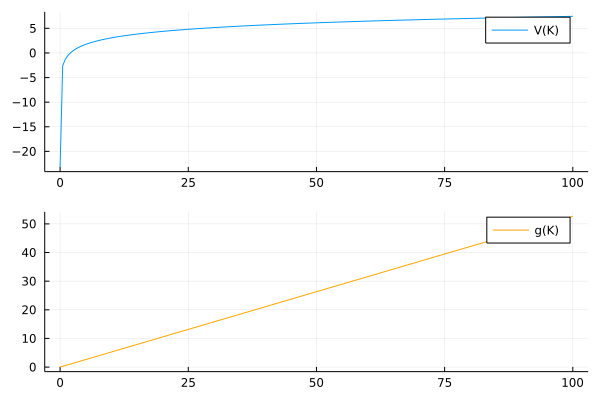

In [197]:
grid_max = 100    # Largest grid point
grid_size = 200    # Number of grid points
K_grid = range(1e-5,  grid_max, length = grid_size)

β=0.9
U(c,k) = log(c) + β * log(k-c)

objectives = (c -> U(c,k) for k in K_grid) # objective for each grid point

results = maximize.(objectives, 1e-10, K_grid) # solver result for each grid point
V_img = Optim.maximum.(results)    
policy_img = Optim.maximizer.(results)

p1=plot(K_grid, V_img, label="V(K)")
p2=plot(K_grid,policy_img, label="g(K)", color=:orange)
plot(p1, p2, layout=(2,1))

### What if there is another day before the end of the world?
Instead of thinking in a sequential way like this:

$$
V_{T-2}(K_{T-2})=max_{c_{T-2},c_{T-1},c_T} \{ u(c_{T-2})+\beta u(c_{T-1}) + \beta^2 u(c_T) \} \text{   subject to:   }K_{T-1}=c_{T-2}c_{T-1}+c_T   \}
$$

We can build on previous work. That is:
$$
V_{T-2}(K_{T-2})=max_{c_{T-2}} \{ u(c_{T-2}) + \beta V_{T-1}(K_{T-1}) \} \text{   subject to:   } K_{T-2}=K_{T-1}+c_{T-2}   \}
$$

We already know the function $V_{T-1}(K)$. In fact, in orther to get the function $V_{T-2}(K)$ the process is almost the same. Again we have to find the value of $c$ that maximices that objective function for a *grid* of $K$.


It is very helpful to read the notebook about *Interpolation*. In a hurry, linear interpolation is taking dots in a plane and conecting them with a straight line. If we are working with a grid as domain and the image of a function in those points of the grid, linear interpolation makes the function continuos

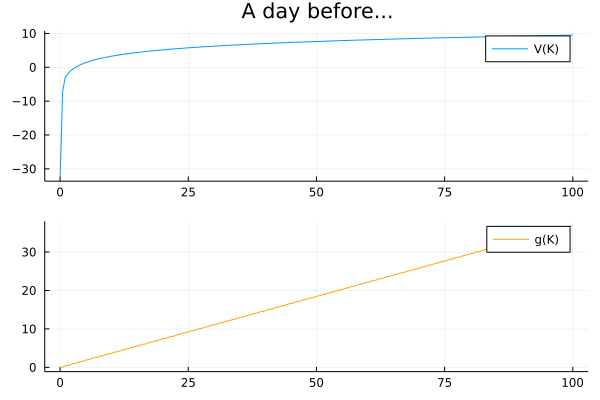

In [198]:
# The previous V(K) now is an element of the objective function to maximize
V_old = LinearInterpolation(K_grid,V_img,extrapolation_bc = Line()) # Linear Interpolation makes it easier
U_new(c,k) = log(c) + β * V_old(k-c)

grid_max = 100    # Largest grid point
grid_size = 200    # Number of grid points
K_grid = range(1e-5,  grid_max, length = grid_size)

objectives = (c -> U_new(c,k) for k in K_grid) # objective for each grid point

results = maximize.(objectives, 1e-10, K_grid) # solver result for each grid point
V_img_new = Optim.maximum.(results)    
policy_img_new = Optim.maximizer.(results)

p1=plot(K_grid_test, V_img_new, label="V(K)",title="A day before...")
p2=plot(K_grid_test,policy_img_new, label="g(K)", color=:orange)
plot(p1, p2, layout=(2,1))

### What happens n days before T?

We simply have to repeat the process. This process that goes backwards a day is called a mapping, which is another way to say function. For convention we will use mapping for something that *eats* functions and *spits* functions (instead of numbers).

So we have:

$$
V_{T-n}=T(V_{T-(n-1)})
$$

For simplicity, we can write:

$$
V_n=T(V_{n-1})
$$


One remarkable thing it is that this mapping is a **contraction**, that is to say that in each step $V_n$ and $V_{n-1}$ are less *different*. In fact it is possible to find a fixed point, in other words a value of $n$ so big that $V_n=V_{n-1}$ (or almost equals). Why does it matter? Because if the problem is infinitely long, we still can find $V$ at time $0$, we do not need to do infinite steps, just some steps.

In [ ]:
# Defining T

